#Correlation between side effects, drug indication and chemical similarity 
Jointplots and pointplots were used to measure the correlation between side effect similarity and chemical similarity as well as drug indication and chemical similarity

In [1]:
import itertools
import math
import gzip

import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import scipy

%matplotlib inline

In [2]:
commit = 'e8567eed2dd48ae0694a0960c518763a777845ff' #commit code is unique to this data

# Read DrugBank compounds
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/{}/data/mapping/pubchem.tsv'.format(commit)
drugbank_df = pandas.read_table(url)
drugbank_df.head()

,drugbank_id,pubchem_id
0,DB00014,11980055
1,DB00014,11981235
2,DB00014,11982741
3,DB00014,16052011
4,DB00014,23581804


In [3]:
#open and read the side effect/indication similarities table
path = '/Users/sabrinalchen/Downloads/similarities.txt.gz'
similarities_df = pandas.read_table(path, header=True, names = ['compound_1', 'compound_2', 'side_effect', 'indication', 'substructure'])
similarities_df.head()

,compound_1,compound_2,side_effect,indication,substructure
0,119,143,0.009857,0.000000,0.22
1,119,174,0.032003,0.000000,0.27
2,119,175,0.023612,0.042896,0.36
3,119,187,NaN,NaN,0.44
4,119,206,0.024511,0.000000,0.28


In [4]:
#change dataframe to use drugbank_id instead of pubmed_id 

drugbank_df.columns = ['drugbank_id', 'compound_1']
spread_df = pandas.merge(drugbank_df, similarities_df)
spread_df.drop('compound_1', axis=1, inplace=True)
spread_df.columns = ['compound_1', 'compound_2', 'side_effect', 'indication', 'substructure']

drugbank_df.columns = ['drugbank_id', 'compound_2']
spread_df = pandas.merge(drugbank_df, spread_df)
spread_df.drop('compound_2', axis=1, inplace=True)
spread_df.columns = ['compound_1', 'compound_2', 'side_effect', 'indication', 'substructure']

spread_df.head()

,compound_1,compound_2,side_effect,indication,substructure
0,DB00014,DB00035,0.099836,0.000000,0.55
1,DB00014,DB00050,0.025077,0.000000,NaN
2,DB00014,DB00091,0.135917,0.000000,NaN
3,DB00014,DB00104,0.121184,0.010754,NaN
4,DB00014,DB00125,0.027033,0.000000,0.18


In [5]:
#open and read the chemical similarities table
path = '/Users/sabrinalchen/Downloads/similarity.tsv.gz'
chem_similarities_df = pandas.read_table(path, header=True, names = ['compound_1', 'compound_2', 'chemical similarity'])
chem_similarities_df.head()

,compound_1,compound_2,chemical similarity
0,DB05107,DB05105,0.0441
1,DB05107,DB05104,0.1457
2,DB05107,DB08423,0.1268
3,DB05107,DB05102,0.1000
4,DB05107,DB08421,0.1875


In [6]:
#merge two dataframes
joined_df = pandas.merge(spread_df, chem_similarities_df)
joined_df.head()

,compound_1,compound_2,side_effect,indication,substructure,chemical similarity
0,DB00014,DB00104,0.121184,0.010754,NaN,0.4080
1,DB00014,DB00125,0.027033,0.000000,0.18,0.1060
2,DB00014,DB04027,0.027033,0.000000,0.18,0.1060
3,DB00014,DB02174,0.050753,0.000000,0.17,0.1011
4,DB00014,DB05314,0.058009,0.000000,NaN,0.1796


In [7]:
#make additional columns for the square root of side effect and indication measures
joined_df['sqrt side effect similarity']= (joined_df['side_effect'])**0.5
joined_df['sqrt indication similarity']= (joined_df['indication'])**0.5
joined_df.head()

,compound_1,compound_2,side_effect,indication,substructure,chemical similarity,sqrt side effect similarity,sqrt indication similarity
0,DB00014,DB00104,0.121184,0.010754,NaN,0.4080,0.348116,0.103703
1,DB00014,DB00125,0.027033,0.000000,0.18,0.1060,0.164416,0.000000
2,DB00014,DB04027,0.027033,0.000000,0.18,0.1060,0.164416,0.000000
3,DB00014,DB02174,0.050753,0.000000,0.17,0.1011,0.225283,0.000000
4,DB00014,DB05314,0.058009,0.000000,NaN,0.1796,0.240851,0.000000


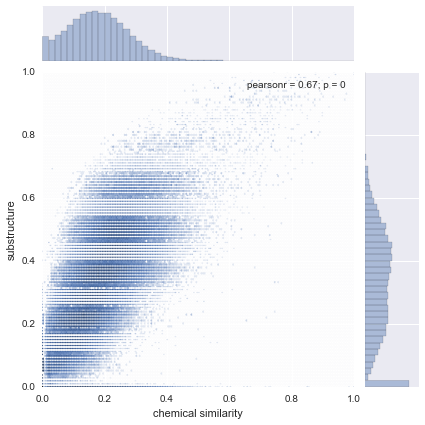

In [8]:
#create joinplot to compare chemical similarity and substructure
x = joined_df['chemical similarity']
y = joined_df['substructure']
substructure = seaborn.jointplot(x,y, bins = "log", kind='hex')
substructure.savefig('figure/substructure.png')

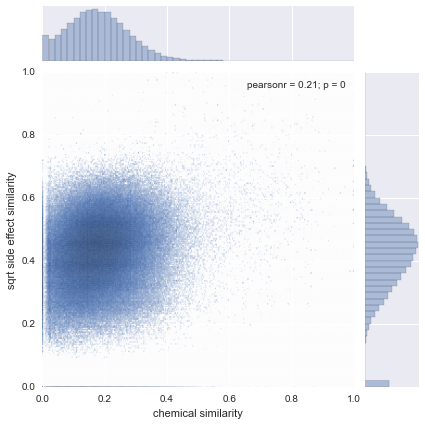

In [9]:
#create joinplot to compare chemical similarity and side effect similarity
x = joined_df['chemical similarity']
y = (joined_df['sqrt side effect similarity']) ** 0.5
side_effect = seaborn.jointplot(x,y, bins = "log", kind='hex')
side_effect.savefig('figure/side_effect.png')

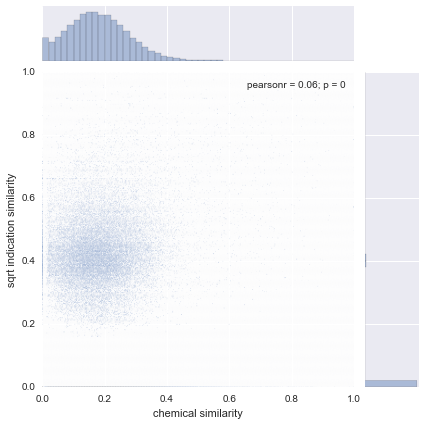

In [10]:
#create joinplot to compare chemical similarity and indication similarity
x = joined_df['chemical similarity']
y = joined_df['sqrt indication similarity'] ** 0.5
indication = seaborn.jointplot(x,y, bins = "log", kind='hex')
indication.savefig('figure/indication.png')

In [11]:
#create side effect mean vs similarity graph

#create column for rounded similarity
joined_df['rounded_similarity'] = joined_df['chemical similarity'].round(decimals = 1)

#group the dataframe by the column for rounded similarity
grouped = joined_df.groupby('rounded_similarity', sort = True)

#sort each section into the means of the jaccard 
grouped = grouped.mean()

#drop the "similarity column" in preparation for graphing
grouped.drop('chemical similarity', axis = 1, inplace = True)

grouped.drop(['side_effect', 'indication', 'substructure'], axis = 1, inplace = True)

#rename the dataframe columns
grouped.columns = ['side effect', 'indication']

grouped = grouped.stack().reset_index()
grouped.columns = ['chemical_similarity', 'type', 'value']
grouped.head()

,chemical_similarity,type,value
0,0.0,side effect,0.146275
1,0.0,indication,0.024969
2,0.1,side effect,0.172193
3,0.1,indication,0.023030
4,0.2,side effect,0.195497


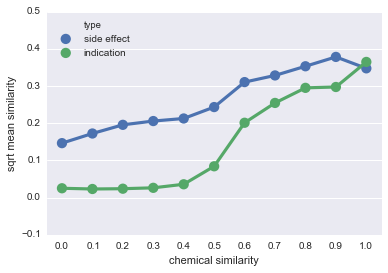

In [12]:
combined_similarity_mean = seaborn.pointplot(x = 'chemical_similarity', y = 'value', hue = 'type', data = grouped)
fig = combined_similarity_mean.get_figure()
plt.xlabel('chemical similarity')
plt.ylabel('sqrt mean similarity')
fig.savefig('figure/combined_similarity_mean.png')

In [13]:
#show the mean breakdown for rounded similarity data
rounded_similarity_df = joined_df.groupby('rounded_similarity').size()
rounded_similarity_df

rounded_similarity
0.0     55207
0.1    177633
0.2    212517
0.3    100574
0.4     23084
0.5      3423
0.6       981
0.7       512
0.8       239
0.9        93
1.0        62
dtype: int64